### 1. Using big query and google storage for data. 
### 2. Scikit for modelling
### 3. And matplot lib for plotting! 


### CLI for big query
Add  or import tables on Google Developer Console Storage. If you have used AWS, it will look familiar to you to create buckets. basically each bucket is like a file system where your project files live. 

https://console.developers.google.com/apis/credentials?project=????

Once you have added your files to the buckets you will have to map those files to big query tables. Create external tables and map the bucket tables with the correct schema. 

Then you will have to enable the API through the api manager by add credentials --> service account --> download p12 or json key. You will need the key to setup the bigquery environment on your machine in order to run jobs. 

See link here to setup the environment. 
pip install bigquery

http://skipperkongen.dk/2013/01/25/toying-with-google-bigquery-python-cli/

https://github.com/tylertreat/BigQuery-Python

connect to plotly by generating an api call 

https://plot.ly/python/getting-started/

python -c "import plotly; plotly.tools.set_credentials_file(username='name', api_key='apikey')"


### The Hacker News data. 
I have taken a keen interest in journalism, mainly how journalism is distributed and monetized for digital publishers. 

Hacker News is the source of best reads I have found. No seriously, I have never been disappointed by hacker news. If I could pay for HN, I would. It is still a small community (in reddit terms). I want to study what type of journalism is being distributed through hacker news. Luckily, they have made their data available on big query. 

The goal of this post is to discuss how to deal with skewed dataset for hierarchical clustering. 

Let's get the data first.
This table is saved as 'test.hn_sampled1'. 


In [ ]:
## here is the query to get the data from big query. The data is publicly available. 
%%sql
SELECT
  REGEXP_EXTRACT((REGEXP_EXTRACT(stories.url,'http://([^/]+)/')),'([^\\.]+\\.[^\\.]+(?:\\.[a-zA-Z].)?)$') AS stories_url_domain,
  COUNT(stories.id) AS stories_count,
  COUNT(stories.deleted) as stories_deleted, 
  count(stories.dead) as stories_dead, 
  sum(descendants) as stories_descandants
FROM
  [fh-bigquery:hackernews.full_201510] AS stories
Where URL != 'null'
GROUP by stories_url_domain
ORDER BY
  stories_count DESC


In [1]:
from bigquery import get_client
from pandas import DataFrame as df
import numpy as np
import pandas as pd

In [2]:
project_id = 'project_id'
SERVICE_ACCOUNT = 'service_account'


key = 'bqclientkey.p12'
client = get_client(project_id, service_account=SERVICE_ACCOUNT,
                    private_key_file=key, readonly=True)

In [3]:
hn_sampled1 = 'test.hn_sampled1'

In [7]:
job_id, _results = client.query('select * from test.hn_sampled1')
job_id = str(job_id)
hn_sampled1_df = df(client.get_query_rows(job_id=job_id))
hn_sampled1_df = hn_sampled1_df.drop('stories_deleted', 1)
print hn_sampled1_df.head()

   stories_count  stories_dead  stories_descandants stories_url_domain
0         328671         53706              1741015               None
1          41722         17138               124154       blogspot.com
2          30923          1151               189618     techcrunch.com
3          28538          1109               224359        nytimes.com
4          17866          4982                11316        youtube.com


My goal is to use the above feature set to cluster the type of news that's being distributed. The hypothesis is that the news will get clustered by main stream news sources (nytimes, wsj), blogs and mid size publishers (tech crunch, engadget), small scale publishers and then all others. Let's see if we can get our algorithm to create these segments successfully using K-means.

In [8]:
# First, let's clean up the data 
matrix = hn_sampled1_df.set_index('stories_url_domain')


matrix = matrix.fillna(0).reset_index()
x_cols = matrix.columns[1:]
print x_cols

Index([u'stories_count', u'stories_dead', u'stories_descandants'], dtype='object')


In [12]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import scale
from scipy.stats import skew, boxcox

In [19]:
# lets check whether the data is normally distributed. 
print 'stories_count:', skew(matrix[['stories_count']]) 
print 'stories_dead:', skew(matrix[['stories_dead']]) 
print 'stories_descandants:', skew(matrix[['stories_descandants']]) 

#should be about 0 for evenly distrubted dataset. 
#>0 means ther is more weight on the left tail of the distributon.

stories_count: [ 397.78432212]
stories_dead: [ 366.71557704]
stories_descandants: [ 398.15175572]


In [22]:
# We can just transform the variables using square root, box cox, or logarithm. 
# You want to be sure you handle all of your variables in the same way in order to avoid introducing bias.
normalized_vars = scale(boxcox(matrix[x_cols]+1)[0])

print skew(matrix[x_cols])

0.686084056969


About boxcox : 
The statisticians George Box and David Cox developed a procedure to identify an appropriate exponent (Lambda = l) to use to transform data into a “normal shape.” The Lambda value indicates the power to which all data should be raised. In order to do this, the Box-Cox power transformation searches from Lambda = -5 to Lamba = +5 until the best value is found. 

The Box-Cox power transformation is not a guarantee for normality. This is because it actually does not really check for normality; the method checks for the smallest standard deviation. The assumption is that among all transformations with Lambda values between -5 and +5, transformed data has the highest likelihood – but not a guarantee – to be normally distributed when standard deviation is the smallest. Therefore, it is absolutely necessary to always check the transformed data for normality using a probability plot.

Additionally, the Box-Cox Power transformation only works if all the data is positive and greater than 0. This, however, can usually be achieved easily by adding a constant (c) to all data such that it all becomes positive before it is transformed. The transformation equation is then (see boxcox implementation above):

 Y’ = (Y+C)l
 
Source: https://www.isixsigma.com/tools-templates/normality/making-data-normal-using-box-cox-power-transformation/

In [24]:
# replacing the matrix with normalized data. 
matrix = pd.merge(normalized_vars, matrix)
matrix = matrix[['stories_url_domain', 'stories_boxcox', 'dead_boxcox', 'stories_descandants']]

In [27]:
# now lets create the clusters. I arbitrarily choose 5. 

cluster = KMeans(n_clusters=5)
matrix['cluster'] = cluster.fit_predict(matrix[matrix.columns[1:]])
matrix.cluster.value_counts()

0    78303
3    29930
2    28156
4    27811
1    21023
Name: cluster, dtype: int64

In [29]:
# looks like cluster 0 has a high data count but all other clusters seem to be fairly evenly distributed. 
# A cool plotting trick for multi dimentional k means analysis is to use PCA (principal component analysis).
# PCA allows us to transform our multi-dim dataset into 2 dim dataset and it becomes easier to plot. 
from sklearn.decomposition import PCA

In [40]:
x_cols = matrix.columns[1:]
pca = PCA(n_components=2)
matrix['x'] = pca.fit_transform(matrix[x_cols])[:,0]
matrix['y'] = pca.fit_transform(matrix[x_cols])[:,1]
matrix = matrix.reset_index()

print matrix.head()

   index stories_url_domain  stories_boxcox  dead_boxcox  cluster         x  \
0      0               None        1.962842     1.914960        3 -2.718135   
1      1       blogspot.com        1.962840     1.914960        3 -2.718135   
2      2     techcrunch.com        1.962839     1.914958        3 -2.718134   
3      3        nytimes.com        1.962839     1.914958        3 -2.718133   
4      4        youtube.com        1.962837     1.914960        3 -2.718133   

          y  
0 -0.442126  
1 -0.442127  
2 -0.442125  
3 -0.442125  
4 -0.442129  


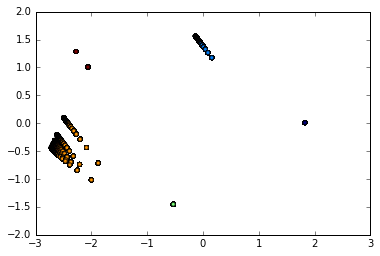

In [56]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

x = matrix['x']
y = matrix['y']
colors = matrix['cluster']
area = 15

plt.scatter(x, y, s=area, c=colors, alpha=0.5)
plt.show()

In [58]:
# Digging deeper into the clusters. I want to see how the clusters are mapped out against variables. 

hn_sampled_with_clusters = pd.merge(hn_sampled1_df, matrix)
print hn_sampled_with_clusters.head()

   stories_count  stories_dead  stories_descandants stories_url_domain  index  \
0         328671         53706              1741015               None      0   
1          41722         17138               124154       blogspot.com      1   
2          30923          1151               189618     techcrunch.com      2   
3          28538          1109               224359        nytimes.com      3   
4          17866          4982                11316        youtube.com      4   

   stories_boxcox  dead_boxcox  cluster         x         y  
0        1.962842     1.914960        3 -2.718135 -0.442126  
1        1.962840     1.914960        3 -2.718135 -0.442127  
2        1.962839     1.914958        3 -2.718134 -0.442125  
3        1.962839     1.914958        3 -2.718133 -0.442125  
4        1.962837     1.914960        3 -2.718133 -0.442129  


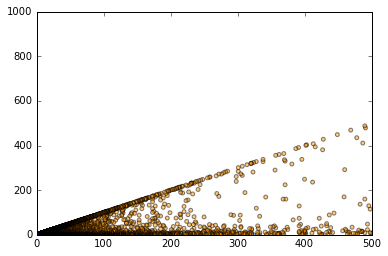

In [63]:
x = hn_sampled_with_clusters['stories_count']
y = hn_sampled_with_clusters['stories_dead']
colors = hn_sampled_with_clusters['cluster']
area = 15

plt.scatter(x, y, s=area, c=colors, alpha=0.5)
plt.xlim(0, 500)
plt.ylim(0, 1000)
    
plt.show()

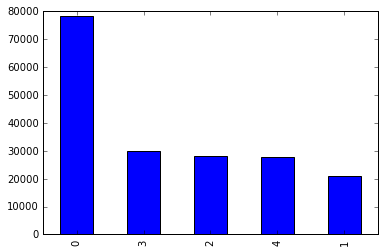

In [65]:
## Clusters visualized. 
matrix.cluster.value_counts().plot.bar()

In [74]:
# Looks like the model is accurately clustering together all of the sites from maintsream sources. In this case, it's cluster 3.  
hn_sampled_with_clusters[hn_sampled_with_clusters.cluster == 3].sort_values(['stories_count'], ascending=False).iloc[1:14, 0:4]

,stories_count,stories_dead,stories_descandants,stories_url_domain
1,41722,17138,124154,blogspot.com
2,30923,1151,189618,techcrunch.com
3,28538,1109,224359,nytimes.com
4,17866,4982,11316,youtube.com
5,15339,2363,55960,wordpress.com
6,13731,277,85972,arstechnica.com
7,12830,361,83899,wired.com
8,11316,429,65904,bbc.co.uk
9,10661,361,69353,wsj.com
10,8893,1116,54896,tumblr.com


In [75]:
# Looks like all the spam sites are clustered together as well as cluster #2
hn_sampled_with_clusters[hn_sampled_with_clusters.cluster == 2].sort_values(['stories_count'], ascending=False).iloc[1:14, 0:4]

,stories_count,stories_dead,stories_descandants,stories_url_domain
149743,1,1,-1,huntingforgeorge.com
149755,1,1,-1,jlbghealth.com
149754,1,1,-1,vegaschill.com
149753,1,1,-1,rongyt.com
149752,1,1,-1,london2012olympics.com.au
149751,1,1,-1,sehat-bebaspenyakit.com
149750,1,1,-1,tkmoneygroup.com
149749,1,1,-1,healthyweightlossways.com
149748,1,1,-1,blue.gg
149747,1,1,-1,docangeles.com
